# [3-22] Exploratory Data Analysis
---
<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Data_visualization_process_v1.png" style="width: 500px; height: 400px;" />


This lab covers the Tukey approach to exploratory data analysis, bringing together key concepts and skills from earlier in the course like data visualization and the train-test-validate split. We will also introduce dimensionality reduction in the form of Principal Components Analysis.

*Estimated Time: 45 minutes*

---

### Table of Contents


1 - [Intro to Exploratory Data Analysis](#section 1)<br>

2 - [EDA and Visualization](#section 2)<br>

3 - [Dimensionality Reduction](#section 3)<br>




**Dependencies:**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

!pip install nltk
import nltk
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

!pip install plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

---
## 1. Introduction to Exploratory Data Analysis <a id='section 1'></a>

> "It is important to understand what you CAN DO before you learn to measure how WELL you seem to have done it." -John W. Tukey, *Exploratory Data Analysis*

Previous labs and many introductory data analysis classes like Data-8 focus on **Confirmatory Data Analysis (CDA)**: the use of statistical methods to see whether the data supports a given hypothesis or model. But, where does the hypothesis come from in the first place?

**Exploratory Data Analysis (EDA)** is the process of 'looking at data to see what it seems to say'. Through this process, we hope to accomplish several things:
- learn about the overall 'shape' of the data: structure, organization, ranges of values
- assess what assumptions we can make about the data as a basis for later statistical inference
- figure out the appropriate tools and techniques for analysis 
- tentatively create testable, appropriate hypotheses or models

EDA is complementary to CDA- in fact, CDA is often only possible after having done EDA. This is clear when compared to the methods of natural sciences: a scientist's research starts with making observations about the world, which leads to questions about what they see. Only after observing and wondering can we begin to systematically test our hypotheses. Similarly, every data analysis project you do should begin with EDA.

Today, we'll go through the EDA process for speech transcripts from [2016 US Presidential campaigns](http://www.presidency.ucsb.edu/2016_election.php). You'll use many coding skills from previous labs. And because EDA is an exploratory process, there are many ways to approach the code (we'll give some tips and guidance). 

In [3]:
# load the data
campaign = pd.read_csv("data/campaign_2016.csv", index_col=0)
campaign.head()

,Candidate,Party,Type,Date,Title,Text
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...


A handy way to get basic summary statistics about your data is using the `.describe()` method on your table. Other useful methods are:
- `.unique()` to look at a column's unique values
- `.value_counts()` to see how often a column's values occur.
- `.isnull()` to screen for null values

From these few methods, we can immediately see things that will affect future analysis options.


In [4]:
# use pandas methods to broadly examine the scope and values of the data
print('data frame summary stats\n', campaign.describe(),'\n\n')
print('unique values for candidates\n', campaign['Candidate'].unique(),'\n\n')
print('number of times a candidate''s name appears\n', campaign['Candidate'].value_counts(),'\n\n')
print('and number of null values\n', campaign.isnull())

data frame summary stats
                Candidate Party           Type               Date  \
count               7485  7485           7485               7485   
unique                21     2              3               1198   
top     Hillary Clinton      R  press release  February 29, 2016   
freq                2504  4205           6214                 34   

                                 Title  \
count                             7485   
unique                            7320   
top     Statement from Hillary Clinton   
freq                                18   

                                                     Text  
count                                                7361  
unique                                               7328  
top     To view this video please enable JavaScript, a...  
freq                                                   10   


unique values for candidates
 ['Jeb Bush' 'Ben Carson' 'Lincoln Chafee' 'Chris Christie'
 'Hillary Clinton ' 'Ted Cruz'

**QUESTION**:
Name at least two issues seen using `describe`, `unique`, `value_counts`, and `isnull`. Why would each issue affect future analysis?
Hint for analyzing `describe`: Which statistics would we expect to be the same for all columns, and are they actually the same? Which column would we expect 'count' to be different from 'unique', and are they?

**ANSWER:**
Count would only be different from unique for the candidate column, since the strings in the 'Text' column will presumably always be different. That's why I only did value counts for that one column. isnull returns a matrix so it is a bit hard to follow but I suppose I could have counted them instead of just getting the boolean values.

As you can see, there are a handful of null values in the 'Text' column. Null values can mess up calculations and need to be dealt with by filling them with a dummy value or deleting the row. Because the null values are for text, and because we're most interested in the text content, we'll drop the offending rows. How you deal with null values will vary on a project-by-project basis.


In [5]:
# drop the null-valued rows with dropna
campaign.dropna(axis=0, how='any', inplace=True)
campaign['Text'].count()

7361

### Feature extraction
Many of numpy and pandas' summary and aggregation methods are built for numerical data, not text. To better understand our data, we use **feature extraction** to create features from transformations of the input features. Some useful features for text would be:
- the number of characters per text
- the number of words per text
- the number of sentences per text
- the average length of words per text
- the average length of sentences per text

Since we're not focusing on data cleaning today (remember the 3/1 lab?), we've provided the code to add columns with lowercase text, word tokens, and sentence tokens that you might find useful. You may also want to revisit the pandas [str methods](https://pandas.pydata.org/pandas-docs/stable/text.html#method-summary).

Note: During EDA, it is always best practice to clearly document what transformations you did, and to add transformed data in new columns rather than transforming the data in place. This will save you a lot of trouble if you need to refer to the original data in the future!

In [6]:
# columns with lowercase, word tokens, sentence tokens
campaign['lower_text'] = campaign['Text'].str.lower()
campaign['words'] = campaign['lower_text'].apply(nltk.word_tokenize)
campaign['sentences'] = campaign['lower_text'].apply(nltk.sent_tokenize)

campaign.head()

,Candidate,Party,Type,Date,Title,Text,lower_text,words,sentences
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco..."
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h..."
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al..."
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi..."
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so..."


In [7]:
type(campaign['words'])

pandas.core.series.Series

In [8]:
# extract features from the text data
campaign['char_count'] = campaign['lower_text'].str.len()
campaign['word_count'] = campaign['words'].str.len()
campaign['sentence_count'] = campaign['sentences'].str.len()
campaign['avg_word_length'] = campaign['char_count']/campaign['word_count']
campaign['avg_sentence_length'] = campaign['char_count']/campaign['sentence_count']

The 'Date' column currently stores dates as strings, which we can't easily compare on a graph. Fortunately, pandas has a **datetime** object that can be easily ordered. Add a column containing string dates that have been transformed into datetime objects. [There's a function](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.to_datetime.html) that might be helpful here...

In [9]:
# convert the 'Date' column to type datetime
campaign['datetime'] = pd.to_datetime(campaign['Date'])
campaign.head()

,Candidate,Party,Type,Date,Title,Text,lower_text,words,sentences,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,datetime
0,Jeb Bush,R,speech,"June 15, 2015",Remarks Announcing Candidacy for President at ...,Thank you all very much. I always feel welcome...,thank you all very much. i always feel welcome...,"[thank, you, all, very, much, ., i, always, fe...","[thank you all very much., i always feel welco...",12383,2338,47,5.296407,263.468085,2015-06-15
1,Jeb Bush,R,speech,"July 30, 2015",Remarks to the National Urban League Conferenc...,Thank you all very much. I appreciate your hos...,thank you all very much. i appreciate your hos...,"[thank, you, all, very, much, ., i, appreciate...","[thank you all very much., i appreciate your h...",14457,2867,126,5.042553,114.738095,2015-07-30
2,Jeb Bush,R,speech,"August 11, 2015",Remarks at the Ronald Reagan Presidential Libr...,Thank you very much. It's good to be with all ...,thank you very much. it's good to be with all ...,"[thank, you, very, much, ., it, 's, good, to, ...","[thank you very much., it's good to be with al...",21283,4061,132,5.240827,161.234848,2015-08-11
3,Jeb Bush,R,speech,"September 9, 2015","Remarks in Garner, North Carolina",Thank you very much. I appreciate your hospita...,thank you very much. i appreciate your hospita...,"[thank, you, very, much, ., i, appreciate, you...","[thank you very much., i appreciate your hospi...",10049,2030,92,4.950246,109.228261,2015-09-09
4,Jeb Bush,R,speech,"November 2, 2015","Remarks in Tampa, Florida",Thank you. It's great to be in Tampa with so m...,thank you. it's great to be in tampa with so m...,"[thank, you, ., it, 's, great, to, be, in, tam...","[thank you., it's great to be in tampa with so...",14189,2564,37,5.533931,383.486486,2015-11-02


We also might be interested in seeing how candidates use particular words. Using a for loop, create a new column for each topic word containing the number of times the word is used in each text.

Hint: take a look at pandas str methods

In [10]:
# create list of possible topics
topics = ['nuclear', 'peace', ' war',
          'north korea', 'russia', 'terror', 'fake news', 'email',
          ' poverty', ' human rights', ' abortion', ' refugee', ' immigration',
          'equality', ' democracy', ' freedom', 'vote', 'energy', 'oil',  'coal',  ' income',
          'economy', 'growth', 'inflation', 'climate change', 'security',
          'cyber', 'trade', 'inequality', 'pollution', 'global warming',
          'education', 'health', 'infrastructure', 'regulation', 'nutrition', 'transportation',
          'violence', 'agriculture', 'crime', 'drugs', 'obesity',
          'islam', 'housing', 'sustainable']


for i in topics:    
    campaign[i] = campaign['lower_text'].str.count(i)



Now that we have numerical data, try using `describe()` again. What's changed now that there's numerical data? What else can you say about this data set?

In [11]:
campaign.describe()

,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,nuclear,peace,war,north korea,russia,...,nutrition,transportation,violence,agriculture,crime,drugs,obesity,islam,housing,sustainable
count,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,...,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000,7361.000000
mean,3142.044559,595.763755,21.988453,5.409715,183.356484,0.144274,0.088439,0.474528,0.019698,0.116017,...,0.005298,0.033284,0.088439,0.023366,0.083684,0.047140,0.002038,0.115338,0.101481,0.017117
std,5218.204517,1047.591396,48.881131,0.523390,200.463907,1.062502,0.728629,2.087992,0.368263,1.537614,...,0.092367,0.285721,0.566912,0.296717,0.823108,0.420378,0.050768,0.778366,0.743924,0.162288
min,3.000000,1.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,967.000000,180.000000,6.000000,5.134228,119.909091,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1698.000000,313.000000,11.000000,5.407273,152.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2898.000000,533.000000,18.000000,5.651852,196.096774,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,81556.000000,15966.000000,877.000000,23.000000,10880.000000,31.000000,29.000000,88.000000,22.000000,79.000000,...,4.000000,10.000000,16.000000,15.000000,54.000000,13.000000,2.000000,21.000000,22.000000,5.000000


### Now that there are numerical data we can tell something about the words that are used in campaign speeches (e.g., Russia seems to come up in the 2016 campaign speeches a lot more than North Korea), although I am not sure why the count summary is always the same as the number of documents in the corpus.

## 2. EDA and Visualization <a id='section 2'></a>

> "The greatest value of a picture is when it *forces* us to notice what we never expected to see." - John W. Tukey, *Exploratory Data Analysis*

Our data set contains almost 7500 records, which is difficult for our brains to parse as a whole. And, this would be considered a fairly small data set by most data science standards. Visualizations are an important tool for summarizing and understanding a data set.

In EDA, we're often interested in a few characteristics:
- where the data is centered (the mean or median)
- how much the data varies from the mean (the spread/variance/standard deviation)
- outliers (the min and max)

The **box plot** is a useful way to visualize all of these things.
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d1/Elements_of_a_boxplot_en.svg/640px-Elements_of_a_boxplot_en.svg.png" />
The rectangular box of the plot holds 50% of the data points. The bottom of the box represents the point that is higher in value than 25% of the data (the lower quartile), and the top of the box represents the point that is higher than 75% of the data (the upper quartile). The whiskers extend on each side to the lowest data point that is within 1.5 times the length of the box (the inter-quartile range, or IQR). All points farther out are graphed as circles (the outliers).

We can make box plots with `plt.boxplot`:

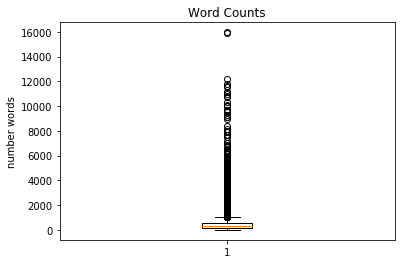

In [12]:
# make a box plot of the word counts
plt.boxplot(campaign['word_count'])
plt.ylabel('number words')
plt.title('Word Counts');

That's an awfully scrunched-up box plot! We can see that over half of our texts contain less than a thousand words, but many texts contain several times that. 

It may be helpful to sort out the different types of texts. Create a dataframe that only has type 'speech', and another dataframe that only has type 'statement'. Then, make a box plot for each. Compare the box plots for word counts to those for word length, sentence length, or character count.

         char_count    word_count  sentence_count  avg_word_length  \
count    430.000000    430.000000      430.000000       430.000000   
mean   17210.469767   3495.234884      151.216279         4.973607   
std    11611.828043   2433.410064      136.046774         0.331227   
min       25.000000      6.000000        1.000000         4.166667   
25%     9651.750000   1924.500000       59.000000         4.722641   
50%    14269.500000   2808.000000      112.000000         4.882661   
75%    22285.000000   4607.000000      205.750000         5.204049   
max    81556.000000  15966.000000      877.000000         6.118762   

       avg_sentence_length     nuclear       peace         war  north korea  \
count           430.000000  430.000000  430.000000  430.000000   430.000000   
mean            163.079812    0.788372    0.667442    2.781395     0.113953   
std             221.459005    2.607923    1.820272    4.139595     0.653868   
min              25.000000    0.000000    0.000000   

Text(0.5,1,'Word Counts for Legit Speeches')

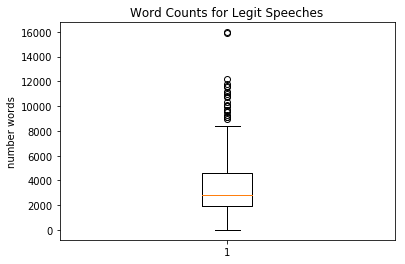

In [13]:
# filter out everything except speeches
speeches = campaign[campaign['Type'] == 'speech']  
# this seems super sloppy with group by index; shouldn't there be a method like .groupby or .filter or something?
print(speeches.describe())
# make a box plot
plt.boxplot(speeches['word_count'].values)
plt.ylabel('number words')
plt.title('Word Counts for Legit Speeches')

type for statements[word_count].values <class 'numpy.ndarray'>


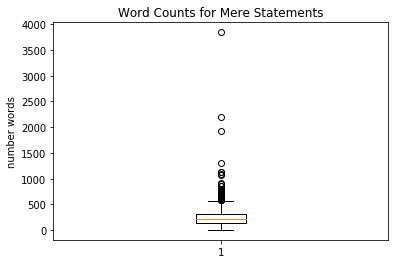

In [14]:
# filter out everything but statements
statements = campaign[campaign['Type'] == 'statement'] 
# print(statements.describe())
# print('datatype for statements[Type]', type(statements['Type']))
# make a box plot
plt.boxplot(statements['word_count'].values)
# Ok, why do I need to cast these as numeric values?
plt.ylabel('number words')
plt.title('Word Counts for Mere Statements')
print('type for statements[word_count].values', type(statements['word_count'].values))

__QUESTION__: what can you conclude about the text data from these box plots?

**ANSWER**: <b> That text data is usually tightly distributed, but that there is also a long right hand tail of stem-winder speeches and long press statements.</b> <p> <b><i>Someone needs to explain why the word_count variable for the statements dataframe has to be turned into a numpy array, but that was not necessary for word_count for speeches.

Box plots pack a lot of information, but the plots can get muddy if many data points overlap. A **Violin plot** is similar to a box plot, but it also shows the distribution of the data at different values (you can think of it like a smoothed histogram).

Look at the word counts, word lengths, and other features using `plt.violinplot`.

Text(0.5,1,'Word Counts for Legit Speeches')

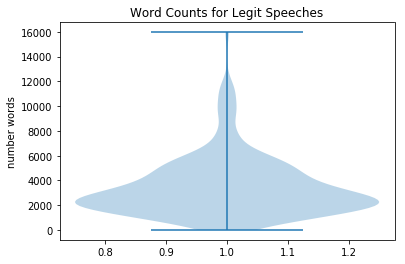

In [15]:
# make a violin plot
plt.violinplot(speeches['word_count'])
plt.ylabel('number words')
plt.title('Word Counts for Legit Speeches')

Text(0.5,1,'Sentence Counts for Campaign Speeches')

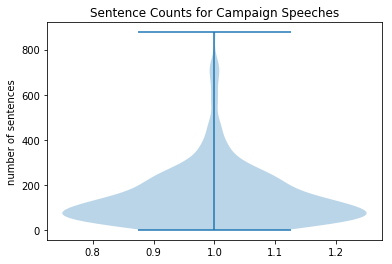

In [16]:
# make another violin plot
plt.violinplot(speeches['sentence_count'].values)
plt.ylabel('number of sentences')
plt.title('Sentence Counts for Campaign Speeches')

**QUESTION**: What can you see with the violin plot that you couldn't with the box plot?

**SOLUTION**: <b>You can better see what the tails of the distribution look like, but if you are used to box-and-whisker plots, it does not tell you much more. Also, the x-axis is not easy to interpret; you are looking at the probability density on both sides of the "1" but the x-axis itself is a standardized number that has no meaning by itself. That may be a reason why we still like box-and-whisker plots.

Unexpected or interesting information may also be found by looking at multiple features together, or by looking at subgroups. 

If you need a refresher on grouping in pandas:

1. select the features you need using `.loc[<rows>, <columns>]`. The rows and columns can be a single label, a list of labels, or a range (e.g. `'word_count':` would give you all columns to the right of and including `word_count`).
2. call `.groupby` with the label of the feature you want to group by
3. call the function you want to use to aggregate the values in each group (e.g. `sum()`, `min()`, `max()`, `mean()`...)

For example, here's a bar plot of the average word count in each candidate's speeches using groupby:


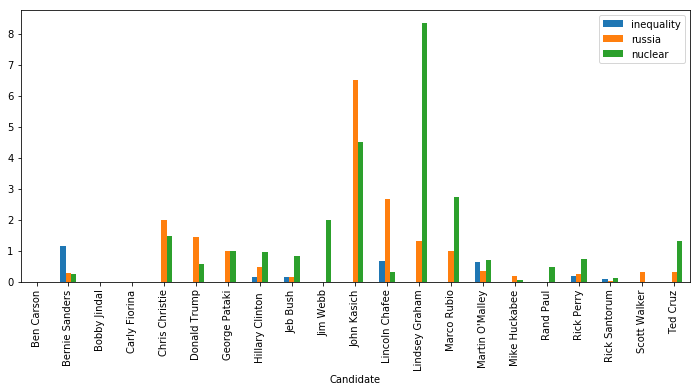

In [17]:
by_candidate = (speeches.loc[:, ['Candidate', 'inequality', 'russia', 'nuclear']] # select all rows, only the columns needed
            .groupby('Candidate') # make groups of word counts for each candidate
            .mean()) # take the average of each group of candidate's word counts

by_candidate.plot.bar(figsize=(12, 5)); # make a bar plot; figsize embiggens it


In the cells below, try creating:
- a line plot showing the average number of times the word 'email' was used on each date (use groupby on the `datetime` column, not `Date`)
- histograms showing the distribution of `word_length` for Democrats and Republicans
- a scatter plot plotting the length of words against the length of sentences for speeches and statements
#### note different results when using just speeches vs speeches & statements; speeches for Republicans is bimodal
Refer to the [pyplot](https://matplotlib.org/tutorials/introductory/pyplot.html#sphx-glr-tutorials-introductory-pyplot-py) and [pandas dataframe plot](https://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-plotting) docs as needed. Feel free to experiment with other groups or features!

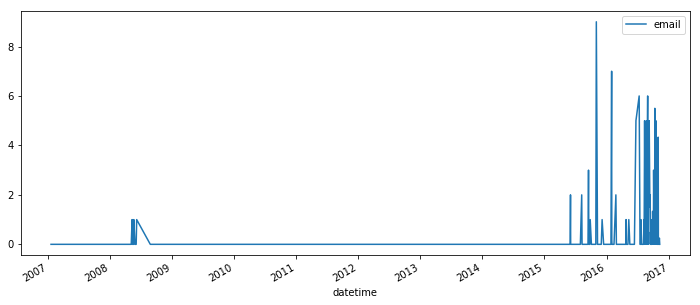

In [18]:
by_date = (speeches.loc[:, ['email', 'datetime']] # select all rows, only the columns needed
            .groupby('datetime') # make groups of word counts for each date
            .mean()) # take the average of date's mention of email

by_date.plot.line(figsize=(12, 5)); # make a line plot; figsize embiggens it

### note that there are some dates way back in time, which are in error; those need to be filtered out

Democrats Average Word Length--Speeches 4.902150077163282 AxesSubplot(0.125,0.125;0.775x0.755)
Republicans Average Word Length--Speeches 5.095397246930121 AxesSubplot(0.125,0.125;0.775x0.755)


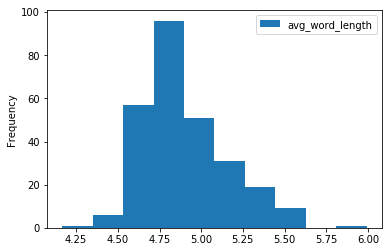

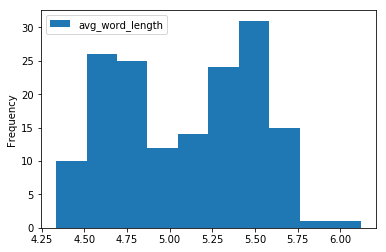

In [19]:
# histograms showing the distribution of word_length for Democrats and Republicans speeches
by_party = (speeches.loc[:, ['Party','avg_word_length']]) # select all rows, only the columns needed
#campaign[campaign['Type'] == 'speech'] note that the solutions use all communications not just speeches              
by_Dems = by_party[by_party['Party']=='D']
by_Reeps = by_party[by_party['Party']=='R']

print('Democrats Average Word Length--Speeches', by_Dems['avg_word_length'].mean(), by_Dems.plot.hist()) # make a Dem histogram 
print('Republicans Average Word Length--Speeches', by_Reeps['avg_word_length'].mean(), by_Reeps.plot.hist()) # make a Rep histogram 

### Interestingly, the Republicans are bimodal, and the Dems have a single mode right between the Republican modes.  Wonder if that is the influence of Trump?

Democrats Average Word Length--Statements 5.444210018471429 AxesSubplot(0.125,0.125;0.775x0.755)
Republicans Average Word Length--Statements 5.4225407883473355 AxesSubplot(0.125,0.125;0.775x0.755)


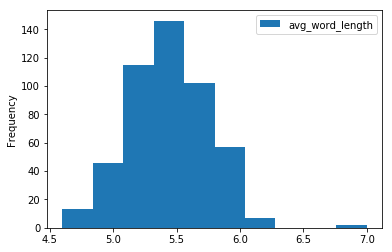

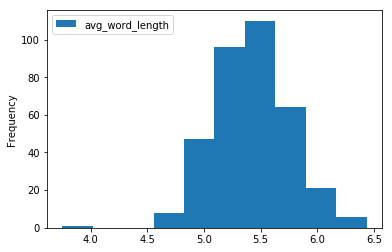

In [20]:
#histograms showing the distribution of word_length for Democrats and Republicans
by_party = (statements.loc[:, ['Party','avg_word_length']]) # select all rows, only the columns needed
#this time we've used statements              
by_Dems = by_party[by_party['Party']=='D']
by_Reeps = by_party[by_party['Party']=='R']

print('Democrats Average Word Length--Statements', by_Dems['avg_word_length'].mean(), by_Dems.plot.hist()) # make a Dem histogram 
print('Republicans Average Word Length--Statements',by_Reeps['avg_word_length'].mean(),by_Reeps.plot.hist()) # make a Rep histogram 

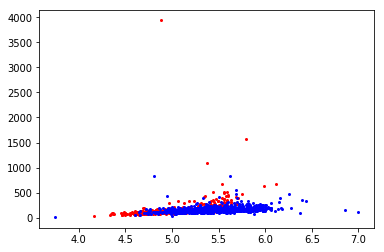

In [21]:
#a scatter plot plotting the average word length against avg. sentence length for speeches, then for statements
plt.scatter(speeches['avg_word_length'].values, speeches['avg_sentence_length'].values, s=4, c='red')
plt.scatter(statements['avg_word_length'].values, statements['avg_sentence_length'].values, s=4, c='blue')

**QUESTION**: What kinds of interesting/suspicious patterns or outliers did you see?
Given what you now know about the data set, what kinds of hypotheses could we test on the data?

**ANSWER**:<b>I don't see that much that is interesting in the scatterplot, except that speeches tend to have longer sentences, and there is an outlier with very long average sentences. That may have happened because of the transcription. I am interested in the bimodal pattern of speeches on the Republican side, especially since the mean word length is similar between the two parties. I suspect Trump is responsible for the lower mode, especially since he was around after the primaries to give speeches. That would be easy to test by separating out Trump speeches or by splitting the speeches by date.

## 3. Principal Components Analysis <a id='section 3'></a>

We've seen that with text analysis, feature matrices get very large, very fast (remember the tf-idf matrix?). To help us visualize high-dimensional data, we can use **Principal Component Analysis (PCA)**.

The goal of PCA is to look for patterns in the data (i.e. correlations between variables). If two variables are strongly correlated, including just one of them in the model might represent the data about as good as if we had them both. PCA looks for variables that account for as much of the variance in the data as possible. This makes it great for **dimensionality reduction**: getting rid of features (dimensions) that don't explain much of the variance in the data so we can more easily manipulate and understand the data.

Note: the details of PCA are hard to follow without some knowledge of linear algebra. If you're interested, check out a more in-depth example [here](https://plot.ly/ipython-notebooks/principal-component-analysis/).

Let's explore variation between *different kinds of texts*: press releases, speeches, and statements. We'll start by using the features we extracted. First, create a table `X` that only has the columns with the extracted numerical features (no string or datetime values) and an array `y` with the classes we want to divide the data into (types of texts). 

In [22]:
# select only the columns with int or float values
X = campaign.iloc[:,9:].drop('datetime',axis=1)
# isn't there a more elegant way to do this by actually selecting columns that have data type int or float?

# select the column with the type classification
y = campaign['Type']

Next, we want to standardize X so that all the features have the same scale (i.e. have an average value of 0 and a standard deviation of 1). Do this by creating a `StandardScaler()`, then run its `fit_transform` method on `X`. You should recognize the syntax from other scikit-learn models.

In [23]:
# scale the data
X_std = StandardScaler().fit_transform(X)

# look at the covariance matrix
np.cov(X_std.T)

array([[ 1.00013587,  0.9954368 ,  0.89851767, ...,  0.18318625,
         0.24198399,  0.23631245],
       [ 0.9954368 ,  1.00013587,  0.92677657, ...,  0.17962126,
         0.2308311 ,  0.22318638],
       [ 0.89851767,  0.92677657,  1.00013587, ...,  0.15573658,
         0.20774027,  0.14612541],
       ...,
       [ 0.18318625,  0.17962126,  0.15573658, ...,  1.00013587,
        -0.01036264,  0.03492686],
       [ 0.24198399,  0.2308311 ,  0.20774027, ..., -0.01036264,
         1.00013587,  0.05314123],
       [ 0.23631245,  0.22318638,  0.14612541, ...,  0.03492686,
         0.05314123,  1.00013587]])

Finally, construct a `PCA` object (set `n_components=2` so we can graph it in two dimensions) and use its `fit_transform` method on your standardized X to get `Y_pca`: the principal components.

In [24]:
# initialize PCA
components = PCA(n_components=2)

# fit the standardized data
Y_pca = components.fit_transform(X_std)

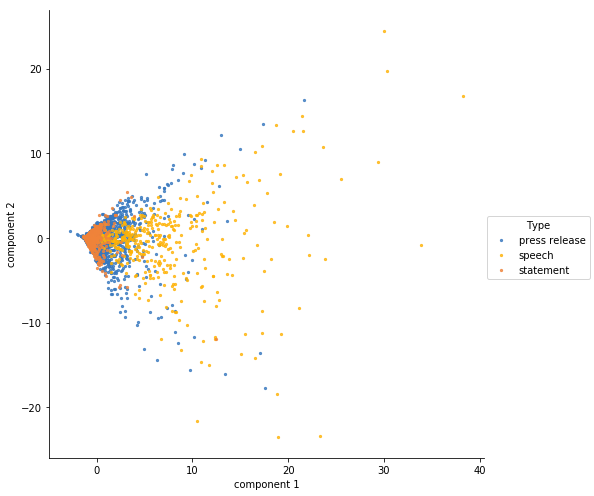

In [25]:
# create a dataframe with the principal components and the classes
components = pd.DataFrame({'component 1': Y_pca[:, 0],
                          'component 2': Y_pca[:, 1],
                          'Type': y})

colors = sns.xkcd_palette(["windows blue", "amber",  "dusty orange"])
# plot
sns.lmplot(x = 'component 1', y = 'component 2', data = components, hue='Type', legend=True, fit_reg=False, 
            hue_order=['press release', 'speech', 'statement'],palette=colors, scatter_kws={'s':5}, size=7);

# Ran out of memory right here and bombs if I go any further on datahub

We can see some separation between different types. This makes sense: we saw in our earlier graphs that different text types tended to have different count and length data. But can we do better?

Let's revisit the tf-idf. As we saw Tuesday, a tf-idf is very high-dimensional, giving information about the frequency of a term in a document and across all documents for every possible term in every document. We can do dimensionality reduction on a tf-idf matrix, too, using **Latent Semantic Analysis (LSA)**. 

The code is very similar, except in this case we don't have to standardize the feature data. First, create a `TfidfVectorizer()` and fit the data in the 'lower_text' column of `campaign` to it to create the sparse tf-idf matrix.


In [26]:
# initialize TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit vectorizer
X = vectorizer.fit_transform(campaign['lower_text'])


Next, do the LSA by created a `TruncatedSVD` object (set `n_components=2`) and fit the sparse tf-idf matrix to it using `fit_transform` (see [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)). You should get a matrix with two values for every text document.

In [27]:
# initialize TruncatedSVD
lsa = TruncatedSVD(n_components=2)

# fit model
Y_lsa = lsa.fit_transform(X)

Now, run the next cell to plot the transformed data.

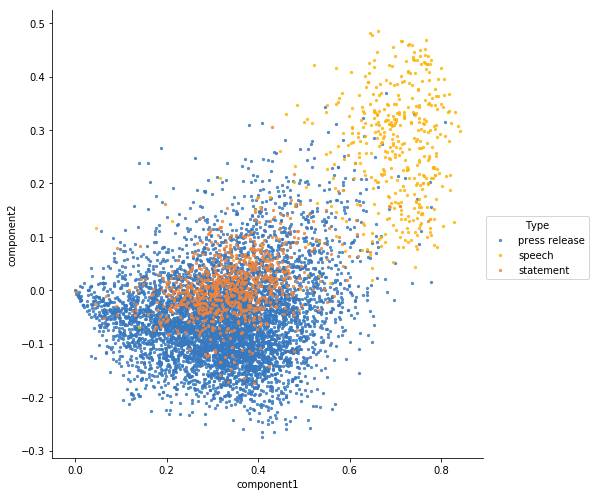

In [28]:
# put components in a data frame
lsa_components = pd.DataFrame({'component1': Y_lsa[:, 0],
                          'component2': Y_lsa[:, 1],
                          'Type': y})
# plot
sns.lmplot(x = 'component1', y = 'component2', data = lsa_components, hue='Type', legend=True, fit_reg=False, 
           hue_order=['press release', 'speech', 'statement'], palette=colors, scatter_kws={'s':5}, size=7);

**QUESTION**: How does this plot compare to the one using PCA and extracted numerical features? What do they both tell you about the variance of the data?

**ANSWER**: <b>This separates the data better than Principal Component Analysis. It tells us that semantically there is not a lot of variance in the data.</b>

Two important notes on PCA:
1. PCA can also be used while training a model for prediction or classification tasks. In that case, like during any model training, you would set aside your test data before doing PCA to avoid overfitting your model.
2. The components output from PCA can't really be described as any specific input features like 'character length'. They're a set of linearly uncorrelated vectors; we can't break it down much more than than, unfortunately.

### Just for fun
Can we do any better if we ask for 3 principal components instead of 2? Run the following cells to see. Does adding an extra dimension capture anything new about the data?

In [29]:
# Initialize models
vectorizer3 = TfidfVectorizer()
lsa3 = TruncatedSVD(n_components=3)

# Fit models
X3 = vectorizer3.fit_transform(campaign['lower_text'])
Y_lsa3 = lsa3.fit_transform(X3)

lsa_3components = pd.DataFrame({'component1': Y_lsa3[:, 0],
                          'component2': Y_lsa3[:, 1],
                            'component3': Y_lsa3[:, 2],
                          'Type': y,
                          'Candidate': campaign.Candidate})


In [30]:
# separate data by type
state = lsa_3components[lsa_components.Type=='statement']
press = lsa_3components[(lsa_components.Type=='press release')]
speech = lsa_3components[(lsa_components.Type=='speech')]

# 3d scatter plot the data
trace_comp0 = go.Scatter3d(
    x=state.component1,
    y=state.component2,
    z=state.component3,
    mode='markers',
    marker=dict(size=3,
                line=dict(width=1),
                color="#f0833a"
               ),
    name='statement',
    text=state.Candidate,
    )

trace_comp1 = go.Scatter3d(
    x=press.component1,
    y=press.component2,
    z=press.component3,
    mode='markers',
    marker=dict(size=3,
                line=dict(width=1),
                color="#3778bf"
               ),
    name='press release',
    text=press.Candidate,
    )

trace_comp2 = go.Scatter3d(
    x=speech.component1,
    y=speech.component2,
    z=speech.component3,
    mode='markers',
    marker=dict(size=3,
                line=dict(width=1),
                color="#feb308"
               ),
    name='speech',
    text=speech.Candidate,
    )

data_comp = [trace_comp0, trace_comp1, trace_comp2]
layout_comp = go.Layout(
    title='LSA',
    hovermode='closest',

)
fig_comp = go.Figure(data=data_comp, layout=layout_comp)
py.iplot(fig_comp, filename='LSA')

---

## Bibliography

- Tukey, J. W. (1977). Exploratory data analysis
- Behrens, J. T. (1997). Principles and procedures of exploratory data analysis. Psychological Methods, 2(2), 131.

---
Notebook developed by: Keeley Takimoto

Data Science Modules: http://data.berkeley.edu/education/modules
